In [1]:
#!pip install scikit-image
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
import os 
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops
from scipy.ndimage import uniform_filter
from skimage.transform import probabilistic_hough_line
from shapely.geometry import LineString, shape
import geopandas as gpd
import rasterio
from rasterio.features import shapes, rasterize
from skimage.draw import line
from ipywidgets import interact, IntSlider, FloatSlider, Checkbox, fixed
import math 
from pyproj import CRS






In [2]:
# Load the DEM
dem_path = r'G:\Lineaments_python\DEM.tiff'
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # read the first band
    profile = src.profile  # keep metadata if needed

# Handle NoData values (optional but recommended)
dem = np.where((dem == src.nodata) | np.isnan(dem), 0, dem)

# Normalize DEM to 8-bit grayscale for cv2 (0-255)
dem_min, dem_max = np.min(dem), np.max(dem)
dem_norm = ((dem - dem_min) / (dem_max - dem_min) * 255).astype(np.uint8)

# Apply Gaussian Blur (helps with noise before Canny)
dem_blurred = cv2.GaussianBlur(dem_norm, (3, 3), 0)


### 1. Detect Lineaments using a Canny Edge Detector
#### Overview
Canny Edge Detection explained [Youtube](https://www.youtube.com/watch?v=sRFM5IEqR2w) 

Canny edge detection is a classic image processing technique that is widely used in lineament detection from DEMs or remote sensing data because of its ability to highlight sharp terrain breaks or linear features. Here's a breakdown of how it works and why it’s useful for lineament detection in geoscience applications.

The Canny algorithm (developed by John F. Canny in 1986) follows these key steps:

1. **Noise Reduction**

The image is first smoothed using a Gaussian filter to suppress noise.

The filter width (σ) controls the level of smoothing — higher values suppress more noise but can blur fine details.

2. **Gradient Calculation**

The first derivative (gradient) of the image is computed using Sobel operators or similar.

Two gradient maps are created:

Gradient magnitude (strength of the edge).

Gradient direction (orientation of the edge).

These gradients reveal where the intensity changes most rapidly — likely edges.

3. **Non-Maximum Suppression**

This step thins the edges to one-pixel width by keeping only local maxima of gradient magnitude along the gradient direction.

4. **Double Thresholding**
Two thresholds are applied:

High threshold: Strong edges (likely real).

Low threshold: Weak edges (kept only if connected to strong ones).

This keeps real edges and discards noise.

5. **Edge Tracking by Hysteresis**

Weak edges connected to strong ones are retained; isolated weak edges are discarded.



In [3]:

def plot_canny_edges(threshold1=1.0, threshold2=10.0):
    # Apply Canny edge detection on the blurred DEM
    edges = cv2.Canny(dem_blurred, threshold1, threshold2)
    
    # Find contours from the detected edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a plot to visualize the DEM and the detected contours
    fig, ax = plt.subplots(figsize=(12, 8))
    dem_show = ax.imshow(dem, cmap='terrain', origin='upper')  # Display the DEM as a background

    # Plot each contour on top of the DEM
    for cnt in contours:
        cnt = cnt.squeeze()  # Remove unnecessary dimensions
        if len(cnt.shape) == 2:  # Ensure the contour is valid
            ax.plot(cnt[:, 0], cnt[:, 1], color='red', linewidth=0.5)  # Plot the contour

    # Add title and remove axes for better visualization
    ax.set_title(f"Canny Edges + Contours\n(threshold1={threshold1}, threshold2={threshold2})")
    ax.axis('off')
    
    # Add a colorbar for the DEM
    plt.colorbar(dem_show, ax=ax, fraction=0.03)
    plt.show()

# Use interactive sliders to adjust the Canny thresholds dynamically
interact(plot_canny_edges,
         threshold1=FloatSlider(min=0.0, max=50.0, step=0.1, value=1.0, description='Threshold 1'),
         threshold2=FloatSlider(min=0.0, max=255.0, step=1.0, value=15.0, description='Threshold 2'));

interactive(children=(FloatSlider(value=1.0, description='Threshold 1', max=50.0), FloatSlider(value=15.0, des…

In [4]:


def export_canny_edges_to_shapefile(
    dem_path,
    threshold1=1.0,
    threshold2=10.0,
    blur_kernel_size=3,
    blur_sigma=1.0,
    export_raster=True,
    output_name=None,
    output_dir='.'
):
    """
    Applies Canny edge detection to a DEM and exports vectorized edges as a shapefile.

    Parameters:
        dem_path (str): Path to the input DEM (GeoTIFF).
        threshold1 (float): Lower Canny threshold.
        threshold2 (float): Upper Canny threshold.
        blur_kernel_size (int): Size of Gaussian kernel (must be odd).
        blur_sigma (float): Sigma for Gaussian blur.
        output_name (str): Base name for shapefile.
        output_dir (str): Directory to save shapefile.
    """
    # Load DEM
    with rasterio.open(dem_path) as src:
        dem = src.read(1)
        profile = src.profile
        transform = src.transform
        crs = src.crs

    # Replace nodata/nan with 0
    dem = np.where((dem == profile.get('nodata')) | np.isnan(dem), 0, dem)

    # Normalize to 8-bit
    dem_min, dem_max = np.nanmin(dem), np.nanmax(dem)
    dem_scaled = ((dem - dem_min) / (dem_max - dem_min) * 255).astype(np.uint8)

    # Ensure odd kernel size
    if blur_kernel_size % 2 == 0:
        blur_kernel_size += 1

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(dem_scaled, (blur_kernel_size, blur_kernel_size), blur_sigma)

    # Canny edge detection
    edges = cv2.Canny(blurred, threshold1, threshold2)

    # Vectorize edges using rasterio.features.shapes
    mask = edges > 0
    shapes_gen = shapes(edges.astype(np.uint8), mask=mask, transform=transform)
    polygons = [shape(geom) for geom, val in shapes_gen if val > 0]

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)

    # Set output name
    thresh1 = int(threshold1)
    thresh2 = int(threshold2)
    base_name = os.path.splitext(os.path.basename(output_name if output_name else dem_path))[0]
    filename = f"{base_name}_T1_{thresh1}_T2_{thresh2}_blur{blur_kernel_size}x{blur_kernel_size}_s{int(blur_sigma)}.shp"
    output_path = os.path.join(output_dir, filename)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Export raster if needed
    if export_raster:
        raster_output = os.path.join(output_dir, f"{base_name}_T1_{thresh1}_T2_{thresh2}_edges.tif")
        raster_profile = profile.copy()
        raster_profile.update({
            'dtype': 'uint8',
            'count': 1,
            'height': edges.shape[0],
            'width': edges.shape[1],
            'driver': 'GTiff'
        })
        if 'nodata' in raster_profile:
            raster_profile.pop('nodata')

        with rasterio.open(raster_output, 'w', **raster_profile) as dst:
            dst.write(edges.astype('uint8'), 1)

    print(f"📦 Edge raster saved to: {raster_output}")

    # Export shapefile
    gdf.to_file(output_path)
    print(f"✅ Exported Canny edge shapefile to: {output_path}")


In [5]:


def plot_shapefile_over_dem(dem_path, shapefile_path, cmap='terrain', figsize=(12, 8), lin_color='red', lin_width=0.5):
    """
    Load and plot a shapefile on top of a DEM.
    """
    import os
    import numpy as np
    import geopandas as gpd
    import rasterio
    import matplotlib.pyplot as plt

    # Load DEM
    with rasterio.open(dem_path) as src:
        dem = src.read(1)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        dem_crs = src.crs

    # Load shapefile
    gdf = gpd.read_file(shapefile_path)
    if gdf.crs != dem_crs:
        print("⚠️ Reprojecting shapefile to match DEM CRS.")
        gdf = gdf.to_crs(dem_crs)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(dem, extent=extent, cmap=cmap, origin='upper')
    gdf.plot(ax=ax, edgecolor=lin_color, linewidth=lin_width)  # Removed aspect='auto'

    # Set aspect ratio manually
    if dem_crs.is_geographic:
        mean_lat = (src.bounds.top + src.bounds.bottom) / 2
        ax.set_aspect(1 / np.cos(np.deg2rad(mean_lat)))
    else:
        ax.set_aspect('equal')

    title = f"{os.path.basename(shapefile_path)} over DEM"
    ax.set_title(title)
    ax.axis('off')
    print("✅ CRS used for plotting:", gdf.crs)
    plt.show()


In [6]:
export_canny_edges_to_shapefile(
    dem_path=r'G:\Lineaments_python\DEM.tiff',
    threshold1=1.0,
    threshold2=12.0,
    blur_kernel_size=3,
    blur_sigma=0.0,
    output_name='Canny_edges',
    output_dir=r'G:\Lineaments_python\output'
)

📦 Edge raster saved to: G:\Lineaments_python\output\Canny_edges_T1_1_T2_12_edges.tif
✅ Exported Canny edge shapefile to: G:\Lineaments_python\output\Canny_edges_T1_1_T2_12_blur3x3_s0.shp


✅ CRS used for plotting: EPSG:4269


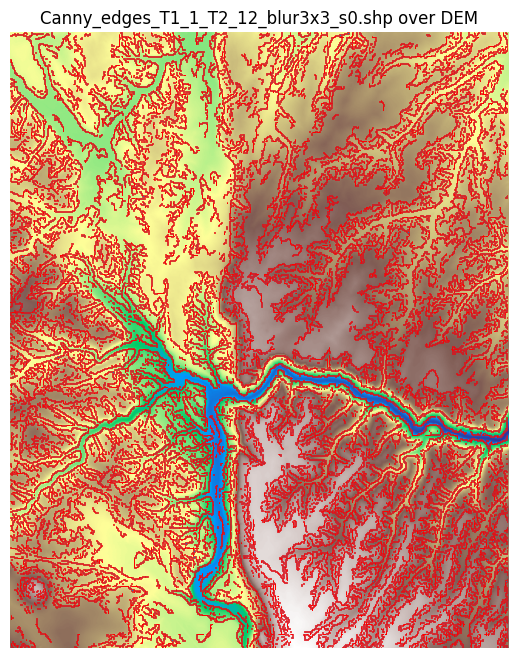

In [7]:
plot_shapefile_over_dem(
    dem_path=r'G:\Lineaments_python\DEM.tiff',
    shapefile_path=r'G:\Lineaments_python\output\Canny_edges_T1_1_T2_12_blur3x3_s0.shp'
)


### Flood Filling 

Local Flood filling is a morphometric approach to detecting linear features or lineaments based on local depressions in a DEM. It’s especially useful in karst or faulted landscapes where lineaments often appear as elongated lows. Here's a detailed breakdown:

This function tries to simulate a localized flood: it identifies pixels that are significantly lower than their surroundings, based on a moving window. Then, it skeletonizes the flooded depressions to extract narrow, elongated features — i.e., potential lineaments or drainage paths.

Steps: 

1. **Local Mean Filtering**
 Applies a uniform (mean) filter over a window_size × window_size neighborhood.The result is a smoothed DEM that represents the local terrain envelope.Think of it as a simplified "local base level".

```python
local_mean = uniform_filter(dem.astype(float), size=window_size, mode='nearest')
```


2. **Flood Detection:**

 A pixel is marked as "flooded" if it is lower than the local mean by more than a threshold (offset, in meters).This creates a binary mask where lower-lying regions are marked as 1.These regions are potential sinks, channels, or fractures — depending on context.

```python
flooded = (dem <= (local_mean - offset)).astype(np.uint8)
```

3. **Skeletonization**

 Uses a thinning algorithm to reduce the flooded regions to 1-pixel-wide centerlines. This is crucial for extracting linear features from the otherwise wide binary blobs.

```python
skeleton = skeletonize(flooded)
```

4. **Labeling & Property Extraction**

 Connected components in the skeleton are identified. For each component, shape properties are computed (via regionprops), e.g.:

 * major_axis_length: how long the feature is.

 * eccentricity: how linear/elongated it is (0 = circle, 1 = line).

```python
labeled = label(skeleton)
props = regionprops(labeled)
```


5. **Filtering Lineaments**

 Filters features to keep only long, linear ones, likely to be lineaments:

 * Length > 20 pixels

 * Eccentricity > 0.9 → nearly straight

```python
if p.major_axis_length > 20 and p.eccentricity > 0.9:

```

6. **Plotting**
 The red contours show the skeletonized linear features.Blue dots mark centroids of qualifying features (potential lineaments).

```python
# --- Plotting ---
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(dem, cmap='terrain', origin='upper')
    ax.contour(skeleton, colors='red', linewidths=0.5)

    for p in props:
        if p.major_axis_length > 20 and p.eccentricity > 0.9:
            y0, x0 = p.centroid
            ax.plot(x0, y0, 'bo', markersize=2)

    ax.set_title(f"Local Flooding (window={window_size}×{window_size}, offset={offset:.1f}m)")
    ax.axis('off')
    plt.colorbar(ax.imshow(dem, cmap='terrain', alpha=0), ax=ax, fraction=0.03)
    plt.show()

```

In [8]:


# --- Local flood detection function ---
def local_flood_and_detect(window_size=11, offset=5.0):
    # Local mean elevation (moving window average)
    local_mean = uniform_filter(dem.astype(float), size=window_size, mode='nearest')
    
    # Flood if pixel is lower than local mean - offset
    flooded = (dem <= (local_mean - offset)).astype(np.uint8)

    # Skeletonize flooded regions
    skeleton = skeletonize(flooded)

    # Label connected features
    labeled = label(skeleton)
    props = regionprops(labeled)

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(dem, cmap='terrain', origin='upper')
    ax.contour(skeleton, colors='red', linewidths=0.5)

    for p in props:
        if p.major_axis_length > 20 and p.eccentricity > 0.9:
            y0, x0 = p.centroid
            ax.plot(x0, y0, 'bo', markersize=2)

    ax.set_title(f"Local Flooding (window={window_size}×{window_size}, offset={offset:.1f}m)")
    ax.axis('off')
    plt.colorbar(ax.imshow(dem, cmap='terrain', alpha=0), ax=ax, fraction=0.03)
    plt.show()

# --- Launch interactive widget ---
interact(local_flood_and_detect,
         window_size=IntSlider(min=3, max=51, step=2, value=15, description='Neighborhood'),
         offset=FloatSlider(min=0.1, max=20.0, step=0.1, value=1.8, description='Offset (m)'));

interactive(children=(IntSlider(value=15, description='Neighborhood', max=51, min=3, step=2), FloatSlider(valu…

In [9]:
def export_local_flood_edges_to_shapefile(
    dem_path,
    window_size=11,
    offset=5.0,
    output_name='FloodFill',
    export_raster=True,
    output_dir='.'
):
    """
    Performs local flooding + skeletonization and exports the result as a shapefile.

    Parameters:
        dem_path (str): Path to input DEM (GeoTIFF).
        window_size (int): Size of local mean window.
        offset (float): Threshold offset below local mean.
        output_name (str): Base name for output shapefile (no extension).
        export_raster (bool): Whether to export the skeletonized raster as GeoTIFF.
        output_dir (str): Output directory.
    """
    # Load DEM
    with rasterio.open(dem_path) as src:
        dem = src.read(1)
        profile = src.profile
        transform = src.transform
        crs = src.crs

    # Clean DEM (replace NaN or nodata with 0)
    dem = np.where((dem == profile.get('nodata')) | np.isnan(dem), 0, dem)

    # Compute local mean
    local_mean = uniform_filter(dem.astype(float), size=window_size, mode='nearest')

    # Flood regions where dem is less than local mean - offset
    flooded = (dem <= (local_mean - offset)).astype(np.uint8)

    # Skeletonize the flooded mask
    skeleton = skeletonize(flooded)

    # Vectorize skeleton pixels to polygons
    shapes_gen = shapes(skeleton.astype(np.uint8), mask=skeleton.astype(bool), transform=transform)
    polygons = [shape(geom) for geom, val in shapes_gen if val > 0]

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)

    # Prepare file paths
    base_name = os.path.splitext(os.path.basename(output_name))[0]
    shapefile_name = f"{base_name}_win{window_size}_off{offset:.1f}.shp"
    shapefile_path = os.path.join(output_dir, shapefile_name)

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Export shapefile
    gdf.to_file(shapefile_path)
    print(f"✅ Skeletonized flooded edges exported to: {shapefile_path}")

    # Optional: Export raster GeoTIFF of the skeleton
    if export_raster:
        raster_name = f"{base_name}_win{window_size}_off{offset:.1f}.tif"
        raster_path = os.path.join(output_dir, raster_name)

        raster_profile = profile.copy()
        raster_profile.update({
            'dtype': 'uint8',
            'count': 1,
            'height': skeleton.shape[0],
            'width': skeleton.shape[1],
            'transform': transform,
            'driver': 'GTiff'
        })

        # Remove nodata (not compatible with uint8)
        if 'nodata' in raster_profile:
            raster_profile.pop('nodata')

        with rasterio.open(raster_path, 'w', **raster_profile) as dst:
            dst.write(skeleton.astype('uint8'), 1)

        print(f"📦 Skeleton raster saved to: {raster_path}")

In [10]:
export_local_flood_edges_to_shapefile(
    dem_path=r'G:\Lineaments_python\DEM.tiff',
    window_size=17,
    offset=1.5,
    output_name='FloodFill',
    output_dir=r'G:\Lineaments_python\output'
)

✅ Skeletonized flooded edges exported to: G:\Lineaments_python\output\FloodFill_win17_off1.5.shp
📦 Skeleton raster saved to: G:\Lineaments_python\output\FloodFill_win17_off1.5.tif


✅ CRS used for plotting: EPSG:4269


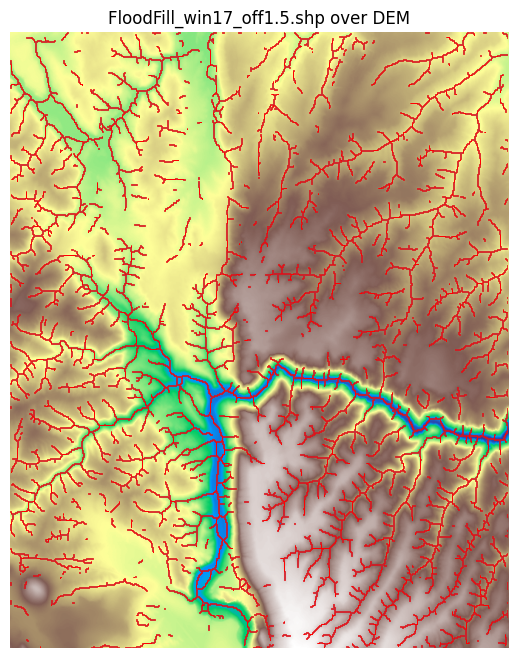

In [11]:
plot_shapefile_over_dem(
    dem_path=r'G:\Lineaments_python\DEM.tiff',
    shapefile_path=r'G:\Lineaments_python\output\FloodFill_win17_off1.5.shp'
)

### Probabalistic Hough Transform

The Probabilistic Hough Transform is a variant of the standard Hough Transform, which is used for detecting lines in images. The standard Hough Transform can be computationally expensive, especially for large images, because it considers all possible lines in the image space. The Probabilistic Hough Transform, on the other hand, samples a subset of points and uses those to detect lines, making it more efficient while still providing good results.
The Probabilistic Hough Transform is particularly useful for detecting lineaments in geospatial data, such as DEMs or remote sensing images, where linear features like faults, fractures, or drainage patterns are of interest. Here's a breakdown of how it works and its application in lineament detection



 ### Hough Transform on the Canny or Flood fill generated edges

 vector-to-raster-based implementation of the probabilistic Hough Transform (cv2.HoughLinesP) to extract and visualize straight-line segments from features (lines or polygons) in a shapefile. It’s especially useful for detecting or enhancing linear features such as faults, dikes, or lineaments, and tuning the parameters interactively.

 1. **Input: Vector and Raster Context**

    * Loads a shapefile containing geometry (likely lineaments or potential structures).

    * Uses a reference raster to match the spatial resolution and extent for rasterization.

    * The shapefile is expected to contain line or polygon geometries.

```python
gdf = gpd.read_file(shapefile_path)
with rasterio.open(reference_raster_path) as src:
    out_shape = (src.height, src.width)
    transform = src.transform

```

2. **Rasterize Vector Features**
    
    * Converts shapefile geometry into a binary raster mask:

            1 = feature pixel (e.g., part of a line or polygon)

            0 = background

    * This creates a binary edge-like image ready for Hough Transform.

```python
mask = rasterize(
    [(geom, 1) for geom in gdf.geometry if geom is not None],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype='uint8'
)
```
3. **Probabilistic Hough Transform (cv2.HoughLinesP)**

Detects straight lines from the binary image.

It’s particularly good at:

Detecting line segments instead of infinite lines (more useful for geologic mapping).

Handling gaps in features.

Enabling control over minimum line length.

```python
lines = cv2.HoughLinesP(edges, rho=rho, theta=theta, threshold=threshold,
                        minLineLength=min_line_length, maxLineGap=max_line_gap)
```

**Explanation of Parameters:**

|Parameter	|Meaning|
|------------------------|-----------------------------------------------------------|
|rho|	Distance resolution in pixels (e.g., 2 = bins every 2 pixels)|
|theta_deg|	Angular resolution in degrees (converted to radians internally)|
|threshold|	Minimum number of votes in the accumulator to be considered a line|
|minLineLength|	Minimum segment length to keep|
|maxLineGap|	Maximum allowed gap between line segments to be connected|
These parameters let you tune the sensitivity and scale of the detected linear features.|


In [12]:
def interactive_hough_lines_p_from_shapefile(
    shapefile_path,
    reference_raster_path,
    default_rho=2,
    default_theta_deg=0.5,
    default_threshold=30,
    default_min_line_length=10,
    default_max_line_gap=4
):
    """
    Interactive HoughLinesP from shapefile input with line plotting.

    Parameters:
        shapefile_path (str): Path to shapefile (lines or polygons).
        reference_raster_path (str): Path to reference DEM or raster (to get shape & transform).
    """
    # Load shapefile
    gdf = gpd.read_file(shapefile_path)

    # Load reference raster
    with rasterio.open(reference_raster_path) as src:
        out_shape = (src.height, src.width)
        transform = src.transform

    # Rasterize shapefile
    mask = rasterize(
        [(geom, 1) for geom in gdf.geometry if geom is not None],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype='uint8'
    )

    def run_hough_p(rho, theta_deg, threshold, min_line_length, max_line_gap):
        theta = np.deg2rad(theta_deg)
        edges = mask.copy()

        lines = cv2.HoughLinesP(edges, rho=rho, theta=theta, threshold=threshold,
                                minLineLength=min_line_length, maxLineGap=max_line_gap)

        fig, ax = plt.subplots(figsize=(12, 8))
        ax.imshow(edges, cmap='gray', origin='upper')
        gdf.plot(ax=ax, edgecolor='cyan', linewidth=0.5)

        count = 0
        if lines is not None:
            for x1, y1, x2, y2 in lines[:, 0]:
                ax.plot([x1, x2], [y1, y2], color='red', linewidth=1)
                count += 1

        ax.set_title(f"HoughLinesP: {count} segments (ρ={rho}, θ={theta_deg:.2f}°, minLen={min_line_length}, gap={max_line_gap})")
        ax.axis('off')
        plt.show()

    interact(
        run_hough_p,
        rho=IntSlider(min=1, max=10, step=1, value=default_rho, description='ρ (pixels)'),
        theta_deg=FloatSlider(min=0.1, max=5.0, step=0.1, value=default_theta_deg, description='θ (°)'),
        threshold=IntSlider(min=5, max=200, step=1, value=default_threshold, description='Threshold'),
        min_line_length=IntSlider(min=5, max=100, step=5, value=default_min_line_length, description='Min Length'),
        max_line_gap=IntSlider(min=1, max=50, step=1, value=default_max_line_gap, description='Max Gap')
    )


#### Default parameters for DEM -> Canny

|Parameter:|       Value:    |Description:|
|-----------------|------------------|-------------------|
|ρ (pixels):|      2         |→ coarse distance resolution, good for long features|
|θ (°):|           0.5      |→ coarse angle resolution, might miss diagonal lines|
|Threshold:|       30        |→ moderate confidence required|
|Min Length:|      10        |→ good for medium-length segments|
|Max Gap:|         4        |→ allows small breaks to be bridged|

In [ ]:
interactive_hough_lines_p_from_shapefile(
    shapefile_path=r'G:\Lineaments_python\output\Canny_edges_T1_1_T2_12_blur3x3_s0.shp',
    reference_raster_path=r'G:\Lineaments_python\DEM.tiff'
)

interactive(children=(IntSlider(value=2, description='ρ (pixels)', max=10, min=1), FloatSlider(value=0.5, desc…

In [14]:


def rasterize_shapefile(shapefile_path, reference_raster_path):
    """
    Rasterizes a shapefile based on a reference raster.

    Returns: mask (np.array), gdf (GeoDataFrame), crs (CRS), transform (Affine)
    """
    gdf = gpd.read_file(shapefile_path)

    with rasterio.open(reference_raster_path) as src:
        out_shape = (src.height, src.width)
        transform = src.transform
        crs = src.crs

    mask = rasterize(
        [(geom, 1) for geom in gdf.geometry if geom is not None],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    return mask, gdf, crs, transform


# ----------------------------------------
# Hough Line Detection and Optional Export
# ----------------------------------------
def run_hough_p(mask, gdf, spatial_ref, transform, rho=2, theta_deg=0.5, threshold=30,
                min_line_length=10, max_line_gap=4, save_lines=True):
    output_dir = os.getcwd()
    theta = np.deg2rad(theta_deg)
    edges = mask.copy()

    lines = cv2.HoughLinesP(edges, rho=rho, theta=theta, threshold=threshold,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(edges, cmap='gray', origin='upper')
    gdf.plot(ax=ax, edgecolor='cyan', linewidth=0.5)

    line_geoms, lengths, angles = [], [], []
    count = 0

    if lines is not None:
        for x1, y1, x2, y2 in lines[:, 0]:
            ax.plot([x1, x2], [y1, y2], color='red', linewidth=1)
            count += 1

            # Convert pixel to geographic coordinates
            pt1 = ~transform * (x1, y1)
            pt2 = ~transform * (x2, y2)
            line_geom = LineString([pt1, pt2])
            line_geoms.append(line_geom)

            dx = pt2[0] - pt1[0]
            dy = pt2[1] - pt1[1]
            length = math.hypot(dx, dy)
            angle = (math.degrees(math.atan2(dy, dx)) + 360) % 180

            lengths.append(length)
            angles.append(angle)

    ax.set_title(f"HoughLinesP: {count} segments (ρ={rho}, θ={theta_deg:.2f}°, minLen={min_line_length}, gap={max_line_gap})")
    ax.axis('off')
    plt.show()

    # Save if needed
    # Save if needed
    if save_lines and line_geoms:
        os.makedirs(output_dir, exist_ok=True)

        # ✅ Explicitly convert spatial_ref to a valid CRS
        spatial_crs = CRS.from_user_input(spatial_ref)
        lines_gdf = gpd.GeoDataFrame({
            'length_m': lengths,
            'angle_deg': angles,
            'geometry': line_geoms
        }, crs=spatial_crs.to_wkt())  # to_wkt avoids ambiguities with EPSG codes

        filename = f"hough_lines_rho{rho}_theta{theta_deg:.2f}_thresh{threshold}_minlen{min_line_length}.shp"
        output_path = os.path.join(output_dir, filename)
        lines_gdf.to_file(output_path)
        print(f"✅ Saved {len(lines_gdf)} lines to: {output_path}")
    elif not save_lines:
        print("ℹ️ Export skipped by user.")
    else:
        print("⚠️ No lines detected.")


In [15]:
shapefile_path = r'G:\Lineaments_python\output\FloodFill_win17_off1.5.shp'
reference_raster_path = r'G:\Lineaments_python\DEM.tiff'

# Rasterize input
mask, gdf, crs, transform = rasterize_shapefile(shapefile_path, reference_raster_path)

with rasterio.open(reference_raster_path) as src:
    crs = src.crs  # This is a proper CRS object

# Define default params
default_rho = 2
default_theta_deg = 0.5
default_threshold = 30
default_min_line_length = 10
default_max_line_gap = 4



In [16]:
# Interact
interact(
    run_hough_p,
    mask=fixed(mask),
    gdf=fixed(gdf),
    spatial_ref=fixed(crs),
    transform=fixed(transform),
    rho=IntSlider(min=1, max=10, step=1, value=default_rho, description='ρ (pixels)'),
    theta_deg=FloatSlider(min=0.1, max=5.0, step=0.1, value=default_theta_deg, description='θ (°)'),
    threshold=IntSlider(min=5, max=200, step=1, value=default_threshold, description='Threshold'),
    min_line_length=IntSlider(min=5, max=100, step=5, value=default_min_line_length, description='Min Length'),
    max_line_gap=IntSlider(min=1, max=50, step=1, value=default_max_line_gap, description='Max Gap'),
    save_lines=Checkbox(value=False, description='Save to Shapefile')
)

interactive(children=(IntSlider(value=2, description='ρ (pixels)', max=10, min=1), FloatSlider(value=0.5, desc…

<function __main__.run_hough_p(mask, gdf, spatial_ref, transform, rho=2, theta_deg=0.5, threshold=30, min_line_length=10, max_line_gap=4, save_lines=True)>

In [17]:
plot_shapefile_over_dem(
    dem_path=r'G:\Lineaments_python\DEM.tiff',
    shapefile_path=r'C:\Users\rl587\Documents\Lineaments_python\sample_data\hough_lines_rho2_theta0.50_thresh25_minlen10.shp'
)


DataSourceError: C:\Users\rl587\Documents\Lineaments_python\sample_data\hough_lines_rho2_theta0.50_thresh25_minlen10.shp: No such file or directory